# Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cProfile
import pstats
import io
import glob as glob
from multiprocessing import Pool
from scipy.optimize import curve_fit
import os
import sqlite3
import pickle

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

import pandas as pd
import ast

In [2]:
def calculate_specific_heat(energies, kB, T, N, dimensions):
    avg_energy = np.mean(energies)
    energy_sq = np.mean(np.array(energies)**2)
    C = (energy_sq - avg_energy**2) / (kB * T**2 * N**dimensions)  # Specific heat
    return C

def initialize_lattice(N, N_alloys):
    radius = int(np.ceil(0.5+np.sqrt(9+12*(N-1))/6)-1) #N1 = 1+ 6*n*(n-1)/2
    # -1 to offset the n meaning here
    points = generate_hexagonal_grid(radius,N_alloys)
    
    return points,radius

########################################################################
mass_gain_df = pd.read_excel("Final_Mass_Gains.xlsx")
##############################################################
diffusion_values = {}
for index, row in mass_gain_df.iterrows():
    # tuple key is sorted so that (a1, a2) and (a2, a1) commute
    key = tuple(sorted((row['Left'], row['Right'])))
    mean = ast.literal_eval(row['Mass_Gain(mg/cm2)'])
    sigma = ast.literal_eval(row['Mass_Gain_Std.Deviation'])
    diffusion_values[key] = (mean, sigma)


def diffusion_couple(a1, a2):
    key = tuple(sorted((a1, a2)))
    # Here we should handle the case where the key doesn't exist, for example with:
    return diffusion_values.get(key, ([10e5], [0]))
###################################################################
def obj_fun(a1,a2):
    if a1==a2:
        return 10e4
    if ((a1>0 and a1<16) and (a2==0 or a2>15)) or ((a2>0 and a2<16) and (a1==0 or a1>15)):
        #print(a1,a2)
        return 10e5
    else:
        beta = 1
        mean,sigma  = diffusion_couple(a1,a2)
        oxidations = np.array(mean) - beta*np.array(sigma)
        return np.sum(oxidations)

def calculate_energy(lattice):
    """Calculate the total energy of the lattice."""
    energy = 0
    for point in lattice:
        for neighbor in point.neighbors:
            energy+= obj_fun(point.alloy,neighbor.alloy)

    return energy/2

def calculate_delta_energy(point1, point2):
    """Calculate the energy difference for a proposed spin swap"""
    energy_before = 0
    energy_after = 0

    for neighbor in point1.neighbors:
        energy_before += obj_fun(point1.alloy,neighbor.alloy)
    #print(energy_before)
    for neighbor in point2.neighbors:
        energy_before += obj_fun(point2.alloy,neighbor.alloy)
    #print(energy_before)

    for neighbor in point1.neighbors:
        energy_after += obj_fun(point2.alloy,neighbor.alloy)
        #print(point2.alloy, neighbor.alloy,energy_after)    
    #print(energy_after)
    for neighbor in point2.neighbors:
        energy_after += obj_fun(point1.alloy,neighbor.alloy)
    #print(energy_after)

    deltaE = energy_after-energy_before
    if deltaE < 0:
        print(deltaE)

    return deltaE

def select_points_with_nonzero_alloy(lattice):
    while True:
        point1, point2 = random.sample(lattice, 2)
        #if point1.alloy != 0 and point2.alloy != 0:
        if (point1.alloy> 0 and point1.alloy<16) and (point2.alloy > 0 and point2.alloy<16):
            return [point1, point2]
        
def metropolis_step(lattice, kB, T, current_energy=None):
    #[point1,point2] = random.sample(lattice, 2)
    [point1,point2] = select_points_with_nonzero_alloy(lattice)

    deltaE = calculate_delta_energy(point1,point2)

    # Update proposal
    if deltaE < 0 :#or np.random.rand() < np.exp(-deltaE / (kB * T)):
        print("Swapping: ", (point1.alloy, point2.alloy))
        '''
        temp = point1.alloy
        point1.alloy = point2.alloy
        point2.alloy = temp
        '''
        point1.alloy, point2.alloy = point2.alloy, point1.alloy
        if current_energy is not None:
            current_energy += deltaE

    return deltaE, current_energy

######################################################################################
def save_simulation_data_sqlite(db_file, steps, lattices, energies, overwrite=False):
    # Connect to the SQLite database
    conn = sqlite3.connect(db_file)
    c = conn.cursor()

    # Create tables if they don't exist
    c.execute('''CREATE TABLE IF NOT EXISTS simulation_steps
                 (step INTEGER PRIMARY KEY, energy REAL)''')
    c.execute('''CREATE TABLE IF NOT EXISTS lattices
                 (step INTEGER, lattice BLOB,
                  FOREIGN KEY(step) REFERENCES simulation_steps(step))''')

    if overwrite:
        # Clear existing data
        c.execute('DELETE FROM simulation_steps')
        c.execute('DELETE FROM lattices')

    # Insert or update rows in the database
    for step, energy, lattice in zip(steps, energies, lattices):
        # Serialize the lattice with Pickle
        pickled_lattice = pickle.dumps(lattice)

        # Insert or replace step data
        c.execute('''INSERT OR REPLACE INTO simulation_steps (step, energy)
                     VALUES (?, ?)''', (step, energy))

        # Insert or replace lattice data
        c.execute('''INSERT OR REPLACE INTO lattices (step, lattice)
                     VALUES (?, ?)''', (step, pickled_lattice))

    # Commit changes and close the connection
    conn.commit()
    conn.close()

def load_simulation_data_sqlite(db_file='simulation_state.sqlite', steps_to_load=None):
    conn = sqlite3.connect(db_file)
    c = conn.cursor()

    # Prepare the query
    query = '''SELECT s.step, s.energy, l.lattice
               FROM simulation_steps s
               LEFT JOIN lattices l ON s.step = l.step'''

    if steps_to_load:
        query += f" WHERE s.step IN ({','.join('?' for _ in steps_to_load)})"
        c.execute(query, steps_to_load)
    else:
        c.execute(query)

    loaded_steps, energies, lattices = [], [], []

    for step, energy, pickled_lattice in c.fetchall():
        # Unpickle the lattice
        lattice = pickle.loads(pickled_lattice) if pickled_lattice else None

        loaded_steps.append(step)
        energies.append(energy)
        lattices.append(lattice)

    conn.close()

    return np.array(loaded_steps), np.array(lattices), np.array(energies)


def load_last_simulation_state(simulation_state_file):
    """Loads the last simulation state from the SQLite database."""
    if not os.path.exists(simulation_state_file):
        return None, None, None, 0  # Indicates that there is no previous state

    with sqlite3.connect(simulation_state_file) as conn:
        cursor = conn.cursor()
        cursor.execute("SELECT MAX(step) FROM simulation_steps")
        last_step = cursor.fetchone()[0]
        if last_step is None:
            return None, None, None, 0

        cursor.execute("SELECT energy FROM simulation_steps WHERE step = ?", (last_step,))
        step_data = cursor.fetchone()
        energy = step_data[0] if step_data else (None)

        cursor.execute("SELECT lattice FROM lattices WHERE step = ?", (last_step,))
        lattice_data = cursor.fetchone()
        lattice = pickle.loads(lattice_data[0]) if lattice_data and lattice_data[0] else None

        return last_step, lattice, energy, last_step
    

def run_simulation_init(N, T, kB, N_alloys, steps=10000, save_interval=100, chunk_size=100, simulation_state_file='simulation_state.sqlite'):
    T +=(10**-6)
    
    # Load last simulation state if exists
    last_step, last_lattice, last_energy, completed_steps = load_last_simulation_state(simulation_state_file)
    
    if completed_steps >= steps:
        print(f"Simulation already completed up to {completed_steps} steps.")
        return True
    
    # Initialize simulation from the last saved state or start a new simulation
    if last_step is not None and last_lattice is not None:
        lattice = last_lattice
        current_energy = last_energy
        start_step = last_step + 1
        print(f"Resuming from step {last_step}.")
    else:
        lattice,radius = initialize_lattice(N, N_alloys)
        current_energy = calculate_energy(lattice)
        start_step = 1
    
    accumulated_steps = []
    accumulated_lattices = []
    accumulated_energies = []

    for step in range(start_step, steps + 1):
        deltaE, current_energy = metropolis_step(lattice, kB, T, current_energy)
        
        if step % save_interval == 0 or step == steps:
            accumulated_steps.append(step)
            accumulated_lattices.append(lattice.copy())
            accumulated_energies.append(current_energy)
            
            if len(accumulated_steps) == chunk_size or step == steps:
                save_simulation_data_sqlite(simulation_state_file, accumulated_steps, accumulated_lattices, accumulated_energies, overwrite=False)
                print(f"Saved step {step}.")
                
                # Clear accumulated data after saving
                accumulated_steps = []
                accumulated_lattices = []
                accumulated_energies = []

    return radius

def run_simulation(initial_lattice, radius, T, kB, steps=10000, save_interval=10, chunk_size=10, simulation_state_file='simulation_state.sqlite'):
    T +=(10**-6)
    
    # Load last simulation state if exists
    last_step, last_lattice, last_energy, completed_steps = load_last_simulation_state(simulation_state_file)
    
    if completed_steps >= steps:
        print(f"Simulation already completed up to {completed_steps} steps.")
        return True
    
    # Initialize simulation from the last saved state or start a new simulation
    if last_step is not None and last_lattice is not None:
        lattice = last_lattice
        current_energy = last_energy
        start_step = last_step + 1
        print(f"Resuming from step {last_step}.")
    else:
        lattice = initial_lattice
        current_energy = calculate_energy(lattice)
        start_step = 1
    
    accumulated_steps = []
    accumulated_lattices = []
    accumulated_energies = []

    for step in range(start_step, steps + 1):
        deltaE, current_energy = metropolis_step(lattice, kB, T, current_energy)
        
        if step % save_interval == 0 or step == steps:
            accumulated_steps.append(step)
            accumulated_lattices.append(lattice.copy())
            accumulated_energies.append(current_energy)
            
            if len(accumulated_steps) == chunk_size or step == steps:
                save_simulation_data_sqlite(simulation_state_file, accumulated_steps, accumulated_lattices, accumulated_energies, overwrite=False)
                print(f"Saved step {step}.")
                
                # Clear accumulated data after saving
                accumulated_steps = []
                accumulated_lattices = []
                accumulated_energies = []

    return radius
########################################################################################
hex_directions = [
    (1, 0), (1, -1), (0, -1),
    (-1, 0), (-1, 1), (0, 1)
]
class LatticePoint:
    def __init__(self, x, y, q, r, alloy):
        self.x = x
        self.y = y
        self.q = q  # Adding axial coordinates
        self.r = r
        self.alloy = alloy
        self.neighbors = []  # Initialize an empty list for neighbors

    def add_neighbor(self, neighbor):
        self.neighbors.append(neighbor)

def hex_to_pixel(q, r, size=1):
    """
    Convert hexagonal grid coordinates (q, r) to Cartesian (x, y).
    Size controls the spacing between the hexagons.
    """
    x = size * (3./2 * q)
    y = size * (np.sqrt(3)/2 * q + np.sqrt(3) * r)
    return (x, y)

def generate_hexagonal_grid(radius,N_alloys):
    points = {}  # Use a dictionary to store points by their (q, r) for easy lookup
    # Generate points
    for q in range(-radius, radius + 1):
        r1 = max(-radius, -q - radius)
        r2 = min(radius, -q + radius)
        for r in range(r1, r2 + 1):
            x, y = hex_to_pixel(q, r)
            alloy = np.random.randint(1, N_alloys+1)  # Random alloy between 1 and 3
            points[(q, r)] = LatticePoint(x, y, q, r, alloy)
    
    # Assign neighbors
    for q, r in points:
        point = points[(q, r)]
        for dq, dr in hex_directions:
            neighbor_coords = (q + dq, r + dr)
            if neighbor_coords in points:
                point.add_neighbor(points[neighbor_coords])
    
    return list(points.values())

def plot_hexagonal_grid_with_neighbors(points, radius=3, q=None, r=None):
    hexagon_radius=1
    fig, ax = plt.subplots(1, figsize=(10,10))
    ax.set_aspect('equal')

    if q==None or r==None:
        # Randomly select a point as the focal point
        focal_point = random.choice(points)
    else:
        # Find the focal point based on q and r
        focal_point = next((point for point in points if point.q == q and point.r == r), None)
    
    if not focal_point:
        print(f"No hexagon found at axial coordinates ({q}, {r}).")
        return
    
    # Highlight the focal point
    focal_hexagon = patches.RegularPolygon(
        (focal_point.x, focal_point.y), numVertices=6, radius=hexagon_radius,
        orientation=np.pi/6, edgecolor='black', facecolor='yellow'
    )
    ax.add_patch(focal_hexagon)
    ax.text(focal_point.x, focal_point.y, str(focal_point.alloy), color='black', fontsize=14, ha='center', va='center')
    
    # Highlight neighbors of the focal point
    for neighbor in focal_point.neighbors:
        neighbor_hexagon = patches.RegularPolygon(
            (neighbor.x, neighbor.y), numVertices=6, radius=hexagon_radius,
            orientation=np.pi/6, edgecolor='black', facecolor='lightblue'
        )
        ax.add_patch(neighbor_hexagon)
        ax.text(neighbor.x, neighbor.y, str(neighbor.alloy), color='red', fontsize=14, ha='center', va='center')

    # Add the rest of the points
    for point in points:
        if point not in focal_point.neighbors and point != focal_point:
            hexagon = patches.RegularPolygon(
                (point.x, point.y), numVertices=6, radius=hexagon_radius,
                orientation=np.pi/6, edgecolor='black', facecolor='none'
            )
            ax.add_patch(hexagon)
            #ax.plot(point.x, point.y, 'o', color='blue')
            ax.text(point.x, point.y, str(point.alloy), color='blue', fontsize=14, ha='center', va='center')

    # Setting the plot limits dynamically based on the hexagon size and grid radius
    plot_radius = hexagon_radius * 2 * (radius+0.1)
    ax.set_xlim(-plot_radius, plot_radius)
    ax.set_ylim(-plot_radius, plot_radius)
    ax.axis('off')  # Hide axis for better visualization
    plt.show()

def custom_init(lattice):
    # Initialize the grid according to experimental_setup.png
    lattice[0].alloy=0
    for i in range(1,2+1):
        lattice[i].alloy= 3-i
    lattice[3].alloy=0

    for i in range(4,8+1):
        lattice[i].alloy = 11-i

    for i in range(9,14+1):
        lattice[i].alloy = 22-i

    lattice[15].alloy=0
    for i in range(16,20+1):
        lattice[i].alloy= 34-i
    lattice[21].alloy=0

    for i in range(22,27+1):
        lattice[i].alloy = 46-i

    for i in range(28,32+1):
        lattice[i].alloy = 57-i

    lattice[33].alloy=0
    for i in range(34,35+1):
        lattice[i].alloy= 65-i
    lattice[36].alloy=0

    return lattice

# Workflow

In [ ]:
# Test visualization
N_alloys = 31
radius = int(np.ceil(0.5+np.sqrt(9+12*(N_alloys-1))/6)-1)

points_with_neighbors = generate_hexagonal_grid(radius,N_alloys)
print(points_with_neighbors)

q_choice, r_choice = None,None#0,0
# Visualization with a randomly chosen point and its neighbors
plot_hexagonal_grid_with_neighbors(points_with_neighbors, q=q_choice, r=r_choice)


In [ ]:
# Test functions
N=31;N_alloys = N
lattice,radius = initialize_lattice(N, N_alloys)
print(len(lattice))
plot_hexagonal_grid_with_neighbors(lattice,radius, 0,0)
current_energy = calculate_energy(lattice)
print(current_energy)
for i in range(10):
    deltaE,current_energy = metropolis_step(lattice, kB=1, T=1, current_energy=current_energy)
plot_hexagonal_grid_with_neighbors(lattice,radius, 0,0)
print(current_energy)

In [ ]:
# Test simulation
run_simulation(N, T=10, kB=1, N_alloys=N_alloys,steps=100000)
loaded_steps, lattices, energies = load_simulation_data_sqlite()

In [ ]:
plt.scatter(loaded_steps,energies)

In [ ]:
print(len(lattices))
plot_hexagonal_grid_with_neighbors(lattices[0])
plot_hexagonal_grid_with_neighbors(lattices[-1])

In [ ]:
1-15 optimize
16-31 non-optimize

120 for non-optimize
20 is max




# Manual lattice preparation:

In [ ]:
N=31;N_alloys = N
lattice,radius = initialize_lattice(N, N_alloys)
print(len(lattice),radius)
plot_hexagonal_grid_with_neighbors(lattice,radius, 0,0)

In [ ]:


plot_hexagonal_grid_with_neighbors(lattice,radius, 0,0)

In [ ]:
init_E = calculate_energy(lattice)
print(init_E)
current_energy = init_E

for i in range(10000):
    deltaE,current_energy = metropolis_step(lattice, kB=1, T=1, current_energy=current_energy)
plot_hexagonal_grid_with_neighbors(lattice,radius, 0,0)
print(current_energy)
print(current_energy-init_E)

In [ ]:
beta=1 ;N=31
filename = "%0.2f-N%d-opt.sqlite" %(beta,N)
run_simulation(lattice, radius, T=10, kB=1, steps=1000, save_interval=1, chunk_size=1, simulation_state_file=filename)
loaded_steps, lattices, energies = load_simulation_data_sqlite(db_file=filename)

In [ ]:
plt.plot(loaded_steps,energies)
plt.yscale('log')
plt.show()
print(len(lattices))
plot_hexagonal_grid_with_neighbors(lattices[-1])

In [ ]:
print(calculate_energy(lattices[0]))
print(calculate_energy(lattices[-1]))
print(calculate_energy(lattices[-1])-calculate_energy(lattices[0]))

-1800033.0803970592
Swapping:  (4, 1)
Saved step 1.
-998887.3590542879
Swapping:  (12, 10)
Saved step 2.
Saved step 3.
-1997431.9890143066
Swapping:  (14, 1)
Saved step 4.
Saved step 5.
-1251.6058989758603
Swapping:  (6, 15)
Saved step 6.
-1800807.0185265436
Swapping:  (5, 4)
Saved step 7.
Saved step 8.
Saved step 9.
Saved step 10.
Saved step 11.
Saved step 12.
-799723.7469406531
Swapping:  (4, 12)
Saved step 13.
-999.5199332926422
Swapping:  (11, 6)
Saved step 14.
-2063.5972857462475
Swapping:  (8, 12)
Saved step 15.
Saved step 16.
Saved step 17.
Saved step 18.
Saved step 19.
Saved step 20.
Saved step 21.
Saved step 22.
Saved step 23.
Saved step 24.
Saved step 25.
Saved step 26.
Saved step 27.
Saved step 28.
Saved step 29.
Saved step 30.
Saved step 31.
Saved step 32.
Saved step 33.
Saved step 34.
Saved step 35.
Saved step 36.
Saved step 37.
Saved step 38.
Saved step 39.
Saved step 40.
Saved step 41.
-723.3881401016843
Swapping:  (7, 14)
Saved step 42.
Saved step 43.
Saved step 44.
Sav

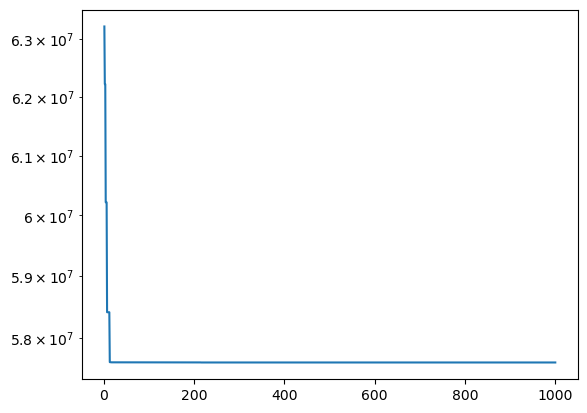

Saved step 1.
Saved step 2.
Saved step 3.
-999803.2899797801
Swapping:  (11, 4)
Saved step 4.
Saved step 5.
Saved step 6.
Saved step 7.
Saved step 8.
Saved step 9.
Saved step 10.
Saved step 11.
Saved step 12.
Saved step 13.
Saved step 14.
Saved step 15.
-800252.0046419268
Swapping:  (10, 15)
Saved step 16.
-999338.2647239519
Swapping:  (10, 4)
Saved step 17.
Saved step 18.
Saved step 19.
Saved step 20.
Saved step 21.
Saved step 22.
-47.09167395438999
Swapping:  (7, 4)
Saved step 23.
Saved step 24.
Saved step 25.
Saved step 26.
Saved step 27.
Saved step 28.
Saved step 29.
Saved step 30.
Saved step 31.
Saved step 32.
Saved step 33.
Saved step 34.
Saved step 35.
Saved step 36.
Saved step 37.
Saved step 38.
Saved step 39.
Saved step 40.
Saved step 41.
Saved step 42.
Saved step 43.
Saved step 44.
Saved step 45.
Saved step 46.
Saved step 47.
Saved step 48.
Saved step 49.
Saved step 50.
Saved step 51.
Saved step 52.
Saved step 53.
Saved step 54.
Saved step 55.
Saved step 56.
Saved step 57.
Sa

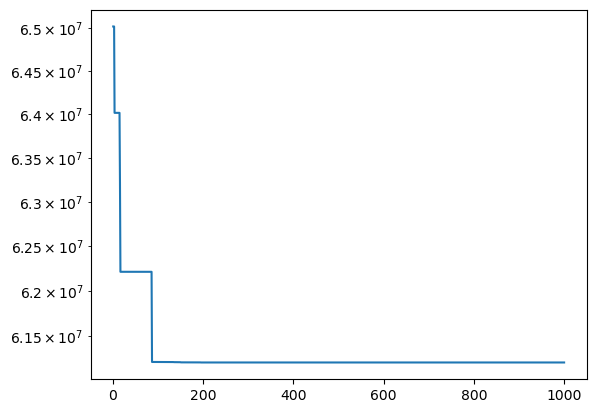

-998532.9708223462
Swapping:  (3, 5)
Saved step 1.
-1000081.0634515584
Swapping:  (4, 13)
Saved step 2.
Saved step 3.
Saved step 4.
Saved step 5.
-1001270.2643057131
Swapping:  (9, 7)
Saved step 6.
Saved step 7.
Saved step 8.
-998869.9169802978
Swapping:  (15, 13)
Saved step 9.
Saved step 10.
Saved step 11.
Saved step 12.
Saved step 13.
Saved step 14.
Saved step 15.
Saved step 16.
Saved step 17.
Saved step 18.
-449.3449396500364
Swapping:  (3, 12)
Saved step 19.
-1657.0981681291014
Swapping:  (2, 3)
Saved step 20.
Saved step 21.
Saved step 22.
Saved step 23.
Saved step 24.
Saved step 25.
Saved step 26.
Saved step 27.
Saved step 28.
Saved step 29.
Saved step 30.
Saved step 31.
Saved step 32.
-196.3060013211798
Swapping:  (1, 6)
Saved step 33.
Saved step 34.
Saved step 35.
Saved step 36.
Saved step 37.
Saved step 38.
Saved step 39.
Saved step 40.
Saved step 41.
Saved step 42.
Saved step 43.
-508.0126868407242
Swapping:  (13, 5)
Saved step 44.
Saved step 45.
Saved step 46.
Saved step 47.


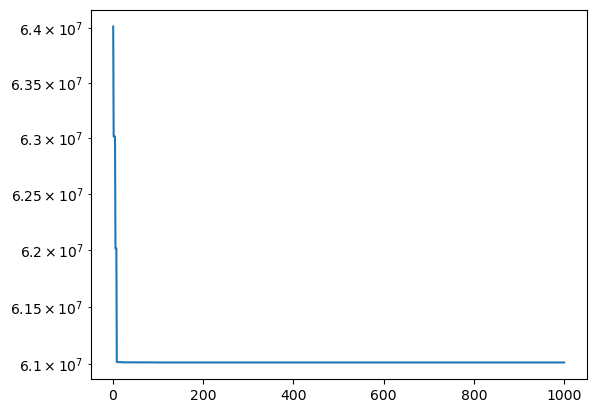

-2000434.2722779093
Swapping:  (15, 5)
Saved step 1.
-998870.6346446378
Swapping:  (12, 10)
Saved step 2.
Saved step 3.
-981.509409845874
Swapping:  (9, 15)
Saved step 4.
Saved step 5.
Saved step 6.
Saved step 7.
-800877.3590534381
Swapping:  (1, 2)
Saved step 8.
Saved step 9.
Saved step 10.
Saved step 11.
-153.12980313505977
Swapping:  (7, 3)
Saved step 12.
Saved step 13.
Saved step 14.
Saved step 15.
Saved step 16.
Saved step 17.
Saved step 18.
Saved step 19.
Saved step 20.
Saved step 21.
Saved step 22.
Saved step 23.
Saved step 24.
Saved step 25.
Saved step 26.
Saved step 27.
Saved step 28.
Saved step 29.
Saved step 30.
Saved step 31.
Saved step 32.
-67.04225208214484
Swapping:  (2, 12)
Saved step 33.
Saved step 34.
Saved step 35.
Saved step 36.
Saved step 37.
Saved step 38.
Saved step 39.
Saved step 40.
Saved step 41.
Saved step 42.
Saved step 43.
Saved step 44.
Saved step 45.
Saved step 46.
-878.7871692189947
Swapping:  (1, 10)
Saved step 47.
Saved step 48.
Saved step 49.
Saved st

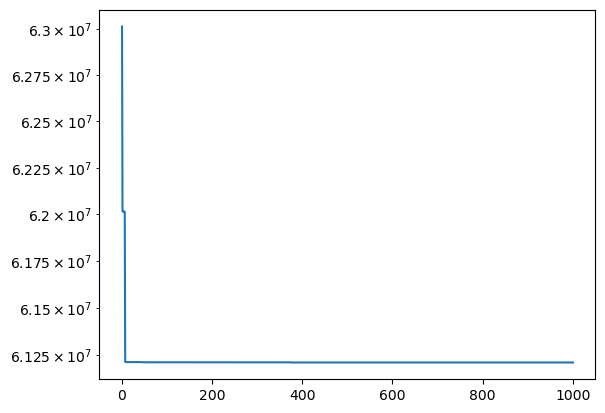

-77.01240172563121
Swapping:  (7, 15)
Saved step 1.
Saved step 2.
-1800290.936961269
Swapping:  (4, 10)
Saved step 3.
-762.5689668729901
Swapping:  (11, 7)
Saved step 4.
Saved step 5.
Saved step 6.
Saved step 7.
Saved step 8.
Saved step 9.
Saved step 10.
Saved step 11.
Saved step 12.
-999365.5983290118
Swapping:  (13, 5)
Saved step 13.
Saved step 14.
Saved step 15.
-856.1637456389144
Swapping:  (8, 12)
Saved step 16.
Saved step 17.
Saved step 18.
Saved step 19.
Saved step 20.
Saved step 21.
Saved step 22.
Saved step 23.
-1999012.6839593833
Swapping:  (12, 10)
Saved step 24.
Saved step 25.
Saved step 26.
Saved step 27.
Saved step 28.
Saved step 29.
Saved step 30.
Saved step 31.
Saved step 32.
Saved step 33.
Saved step 34.
Saved step 35.
Saved step 36.
Saved step 37.
Saved step 38.
Saved step 39.
Saved step 40.
Saved step 41.
Saved step 42.
Saved step 43.
Saved step 44.
-999576.8336886936
Swapping:  (2, 15)
Saved step 45.
Saved step 46.
Saved step 47.
Saved step 48.
Saved step 49.
Saved 

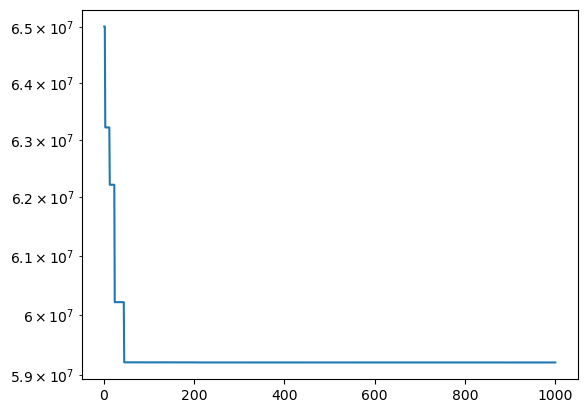

Saved step 1.
-800669.5879955487
Swapping:  (5, 4)
Saved step 2.
-1998787.1840836587
Swapping:  (12, 1)
Saved step 3.
Saved step 4.
Saved step 5.
Saved step 6.
-799430.8186365878
Swapping:  (10, 5)
Saved step 7.
-615.4866487914696
Swapping:  (12, 15)
Saved step 8.
Saved step 9.
Saved step 10.
Saved step 11.
Saved step 12.
Saved step 13.
Saved step 14.
Saved step 15.
-660.7233985513449
Swapping:  (1, 4)
Saved step 16.
Saved step 17.
Saved step 18.
Saved step 19.
Saved step 20.
Saved step 21.
Saved step 22.
Saved step 23.
Saved step 24.
Saved step 25.
Saved step 26.
Saved step 27.
Saved step 28.
Saved step 29.
-312.84468932822347
Swapping:  (12, 7)
Saved step 30.
-800170.4834389607
Swapping:  (10, 1)
Saved step 31.
Saved step 32.
Saved step 33.
Saved step 34.
Saved step 35.
Saved step 36.
Saved step 37.
Saved step 38.
-999483.8589402018
Swapping:  (2, 13)
Saved step 39.
Saved step 40.
Saved step 41.
Saved step 42.
Saved step 43.
Saved step 44.
Saved step 45.
Saved step 46.
Saved step 47.

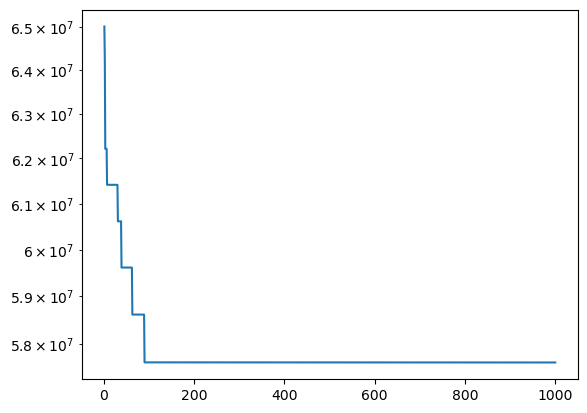

-1800166.8073203284
Swapping:  (4, 3)
Saved step 1.
Saved step 2.
Saved step 3.
-999033.5103813063
Swapping:  (7, 1)
Saved step 4.
Saved step 5.
Saved step 6.
Saved step 7.
Saved step 8.
Saved step 9.
Saved step 10.
Saved step 11.
Saved step 12.
Saved step 13.
Saved step 14.
Saved step 15.
Saved step 16.
Saved step 17.
Saved step 18.
Saved step 19.
Saved step 20.
-3397.8795191638637
Swapping:  (13, 9)
Saved step 21.
-898.6894062273204
Swapping:  (11, 9)
Saved step 22.
Saved step 23.
Saved step 24.
Saved step 25.
Saved step 26.
Saved step 27.
Saved step 28.
Saved step 29.
Saved step 30.
Saved step 31.
Saved step 32.
Saved step 33.
Saved step 34.
-998365.4160975851
Swapping:  (3, 14)
Saved step 35.
Saved step 36.
Saved step 37.
Saved step 38.
Saved step 39.
Saved step 40.
Saved step 41.
Saved step 42.
Saved step 43.
Saved step 44.
Saved step 45.
Saved step 46.
Saved step 47.
Saved step 48.
Saved step 49.
Saved step 50.
Saved step 51.
Saved step 52.
Saved step 53.
Saved step 54.
Saved ste

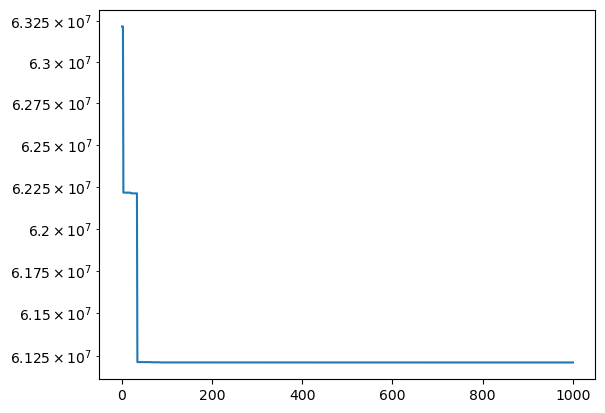

-800669.5879955487
Swapping:  (5, 4)
Saved step 1.
-998927.0918538719
Swapping:  (8, 4)
Saved step 2.
Saved step 3.
-801211.5850868705
Swapping:  (1, 2)
Saved step 4.
-999022.4074794571
Swapping:  (3, 12)
Saved step 5.
-235.68252816377208
Swapping:  (6, 15)
Saved step 6.
Saved step 7.
Saved step 8.
Saved step 9.
-1195.480140910484
Swapping:  (7, 4)
Saved step 10.
Saved step 11.
Saved step 12.
-1000496.0726034986
Swapping:  (13, 11)
Saved step 13.
Saved step 14.
-281.26848346553743
Swapping:  (11, 8)
Saved step 15.
-799626.2160161734
Swapping:  (3, 13)
Saved step 16.
Saved step 17.
Saved step 18.
Saved step 19.
Saved step 20.
Saved step 21.
Saved step 22.
Saved step 23.
Saved step 24.
Saved step 25.
Saved step 26.
Saved step 27.
-184.74970763595775
Swapping:  (12, 6)
Saved step 28.
Saved step 29.
-6.959040271118283
Swapping:  (7, 11)
Saved step 30.
Saved step 31.
Saved step 32.
Saved step 33.
Saved step 34.
-12.66644172091037
Swapping:  (12, 11)
Saved step 35.
Saved step 36.
Saved step 

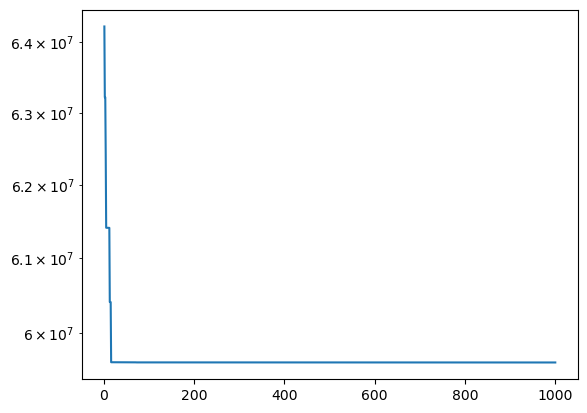

Saved step 1.
Saved step 2.
-180.07622450310737
Swapping:  (12, 15)
Saved step 3.
Saved step 4.
Saved step 5.
Saved step 6.
-504.0102089480497
Swapping:  (13, 5)
Saved step 7.
Saved step 8.
Saved step 9.
Saved step 10.
-2000946.6481933405
Swapping:  (13, 9)
Saved step 11.
Saved step 12.
Saved step 13.
-409.3226496214047
Swapping:  (15, 12)
Saved step 14.
Saved step 15.
Saved step 16.
-209.95278801815584
Swapping:  (6, 10)
Saved step 17.
Saved step 18.
Saved step 19.
Saved step 20.
Saved step 21.
Saved step 22.
Saved step 23.
Saved step 24.
Saved step 25.
Saved step 26.
Saved step 27.
-999215.7895086547
Swapping:  (5, 10)
Saved step 28.
Saved step 29.
Saved step 30.
Saved step 31.
Saved step 32.
Saved step 33.
Saved step 34.
Saved step 35.
Saved step 36.
Saved step 37.
Saved step 38.
Saved step 39.
Saved step 40.
Saved step 41.
-595.1657959092408
Swapping:  (1, 6)
Saved step 42.
Saved step 43.
Saved step 44.
Saved step 45.
Saved step 46.
Saved step 47.
Saved step 48.
Saved step 49.
Save

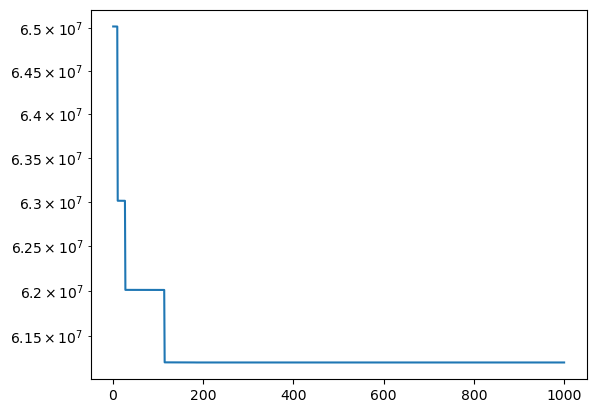

Saved step 1.
Saved step 2.
-274.07357367826626
Swapping:  (6, 10)
Saved step 3.
-665.0378360194154
Swapping:  (6, 1)
Saved step 4.
Saved step 5.
Saved step 6.
Saved step 7.
Saved step 8.
Saved step 9.
-533.5557275488973
Swapping:  (4, 13)
Saved step 10.
Saved step 11.
Saved step 12.
Saved step 13.
Saved step 14.
Saved step 15.
-1799155.4781309185
Swapping:  (2, 10)
Saved step 16.
-34.159463631687686
Swapping:  (7, 3)
Saved step 17.
Saved step 18.
Saved step 19.
-2003.3631521747448
Swapping:  (9, 6)
Saved step 20.
-998669.4312491147
Swapping:  (1, 10)
Saved step 21.
Saved step 22.
Saved step 23.
-998662.6979544179
Swapping:  (5, 3)
Saved step 24.
Saved step 25.
Saved step 26.
Saved step 27.
Saved step 28.
-1000191.4581906404
Swapping:  (4, 9)
Saved step 29.
Saved step 30.
-181.35397114837542
Swapping:  (9, 2)
Saved step 31.
Saved step 32.
Saved step 33.
Saved step 34.
Saved step 35.
Saved step 36.
Saved step 37.
Saved step 38.
Saved step 39.
Saved step 40.
Saved step 41.
Saved step 42.

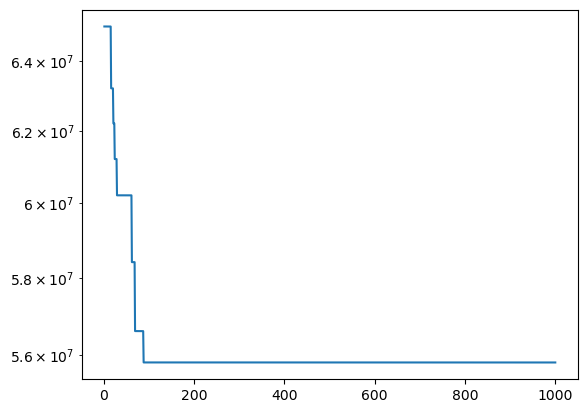

In [4]:
rand_E = np.zeros((10,1000))

for i in range(10):
    N=31;N_alloys = N; beta = 1
    lattice,radius = initialize_lattice(N, N_alloys)
    lattice = custom_init(lattice)
    filename = "%0.2f-N%d-opt-%d.sqlite" %(beta,N,i)
    run_simulation(lattice, radius, T=10, kB=1, steps=1000, save_interval=1, chunk_size=1, simulation_state_file=filename)
    loaded_steps, lattices, energies = load_simulation_data_sqlite(db_file=filename)
    plt.plot(loaded_steps,energies)
    plt.yscale('log')
    plt.show()
    rand_E[i] = energies

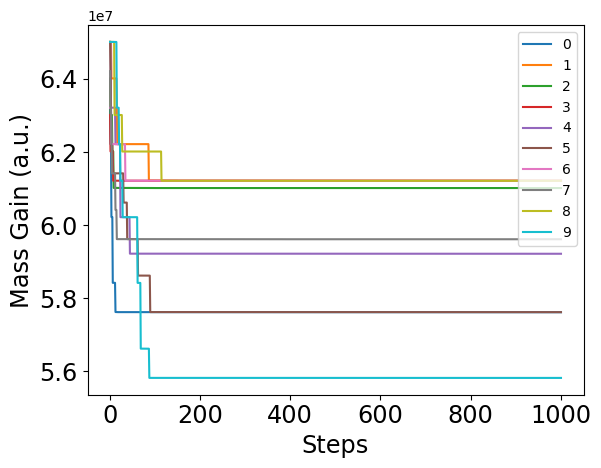

In [10]:
for i in range(10):
    plt.plot(loaded_steps,rand_E[i,:], label=i)
plt.xticks(size='xx-large')
plt.yticks(size='xx-large')
plt.xlabel("Steps",size='xx-large')
plt.ylabel("Mass Gain (a.u.)",size='xx-large')
plt.legend()
plt.show()